# Modeling
I will start by running my data through some Naive Bayes models, Logistic Regression, Random Forest and Ada Boost. In this notebook I will leave the stopwords to the english dictionary, based on my [EDA](./2_eda_%26_cleaning.ipynb), there weren't any identifiable words that made it in the categories' top 25 words. I will only run the lyrics column through the models with the target being the skip column.



#### Table of Contents
<br>`Pre-Processing`</br>

- [Baseline & Target](#target)
- [Pipeline & GridSearch Function](#func)

<br>`Modeling`</br>

- [MultinomialNB](#Mnb)
- [BernoulliNB](#Bnb)
- [Logistic Regression](#Lg)
- [Ada Boost](#ada)
- [Random Forest](#forest)

<br>`Conclusion`</br>

- [Feat Importance of Best Model](#feat)
- [Model Score Visualizations](#viz)
- [Notebook Conclusion](#conc)    

### Libraries

In [91]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text # to add more stopwords

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, f1_score, recall_score

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


In [2]:
df = pd.read_csv('./data/lyrics_cleaned.csv')

### Baseline<a id='target'></a>  
Because my class in so imbalanced I will not be using accuracy as my score, instead I will be looking at variations of F1 score, confusion matrix, and precision score which are all ideal for imbalanced classes. The reason accuracy is not ideal is because accuracy will always predict on the heavier class when imbalanced.

In [3]:
df["skip"].value_counts(normalize=True) #Baseline

0    0.75993
1    0.24007
Name: skip, dtype: float64

There are some words that I don't want displayed on screen so I will replace them as 'vulgar', they can still help my model with it's predictions. These words are not so much easy predictors, as much as they are words that I don't feel comfortable being part of my visualizations or my publicly viewable project.

In [4]:
some_words = open("./data/drop_words.txt").read().split()

for i in some_words:   
    df['lyrics'] = df['lyrics'].str.lower().str.replace(rf"\b{i}\b", 'vulgar')

### Train Test Split
As mentioned earlier, I will use the lyrics column in my models with my target being the skip column. All other columns were made for EDA purposes.

In [5]:
X = df['lyrics']
y = df['skip']

In [6]:
# since the categories are unbalanced I will stratify y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y) 
# Check shapes of the split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8591,), (2864,), (8591,), (2864,))

### Pipeline Function<a id='func'></a>  
I am re-using the pipeline function I made for my Reddit project NLP. Which allows me to put in various models and Vectorizer and returns scores along with confusion matrices. In addition I have added some empty lists that the scores will append to, so that I can create a visualization of the score breakdown for each model and vectorizer

In [7]:
train_f1 = []
test_f1 = []
train_gs =[]
test_gs = []
precision = []
recall = []
specificity =[]

In [9]:
def start_pipeline(vect, model, color, pipe_params): # takes type of vectorizer, model, color of confusion matrix, and pipe params
    
    # Types of Vectorizers
    if vect == 'cv':
        instantiate_vect = CountVectorizer
        vect_name = 'CountVectorizer'
    elif vect == 'tvec':
        instantiate_vect = TfidfVectorizer
        vect_name = 'TfidfVectorizer'
        
      # Types of Models  
    if model == 'Mnb':
        instantiate_model = MultinomialNB
        model_name = 'MultinomialNB'
    elif model == 'Bnb':
        instantiate_model = BernoulliNB
        model_name = 'BernoulliNB'
    elif model == 'lg':
        instantiate_model = LogisticRegression
        model_name = 'LogisticRegression'
    elif model == 'ada':
        instantiate_model = AdaBoostClassifier
        model_name = 'AdaBoostClassifier'     
    elif model == 'rdf':
        instantiate_model = RandomForestClassifier
        model_name = 'RandomForestClassifier'
  
          
        
        #----- Pipeline-----#
    
    pipe = Pipeline([
    (vect , instantiate_vect(stop_words = 'english')), # transformer
    (model , instantiate_model()) # estimator
    ])

    # --- Gridsearch----#
    gs = GridSearchCV(pipe,
                 pipe_params, # defined outside of function for easy change
                 cv=5,
                 verbose = 1,
                 n_jobs=-1)
    
    
    gs.fit(X_train,y_train) # fitting X_train and y_train
    preds = gs.predict(X_test) # predict test
    train_preds = gs.predict(X_train) # predict train
    
    #------ Scores & Params------- #
    print(f'Gridsearch best score is: {gs.best_score_}') # grid search's best score
    print('')
    print(f'Gridsearch best params are: {gs.best_params_}') # based on best score give me best params
    print('')
    print(f'{model_name} with {vect_name} Train Score :  {gs.score(X_train, y_train)*100:.2f}%') 
    train_gs.append(gs.score(X_train, y_train))
    print(f'{model_name} with {vect_name}  Test Score  : {gs.score(X_test, y_test)*100:.2f}%')
    test_gs.append(gs.score(X_test, y_test))
    print('')
    print(f'{model_name} with {vect_name}  F1- Train Score: {f1_score(y_train, train_preds)*100:.2f}%')
    train_f1.append(f1_score(y_train, train_preds))
    print(f'{model_name} with {vect_name}  F1- Test Score:  {f1_score(y_test, preds)*100:.2f}%')
    test_f1.append(f1_score(y_test, preds))
    print('')
    
     # ----- Predictions ------ #
        
    print(f"{(precision_score(y_test, preds))*100:.2f}% of the songs were predicted correctly by the model.")
    precision.append(precision_score(y_test, preds))
    print(f"{(recall_score(y_test, preds))*100:.2f}% of the Skipped songs were found.")
    recall.append(recall_score(y_test, preds))
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    print(f"The specificity(Not Skipped Songs) is: {(tn / (tn + tp))*100:.2f}%")
    specificity.append((tn / (tn + tp)))
    
    plot_confusion_matrix(gs, X_test, y_test, cmap= color);
    

### Multinomial Naive Bayes with Count Vectorizer<a id='Mnb'></a>  

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.2min finished


Gridsearch best score is: 0.7893135069865591

Gridsearch best params are: {'cv__max_df': 0.5, 'cv__max_features': 5000, 'cv__min_df': 2, 'cv__ngram_range': (1, 1)}

MultinomialNB with CountVectorizer Train Score :  81.74%
MultinomialNB with CountVectorizer  Test Score  : 79.05%

MultinomialNB with CountVectorizer  F1- Train Score: 65.25%
MultinomialNB with CountVectorizer  F1- Test Score:  60.58%

55.28% of the words were predicted correctly by the model.
67.01% of the Skipped songs were found.
The specificity is: 79.64%


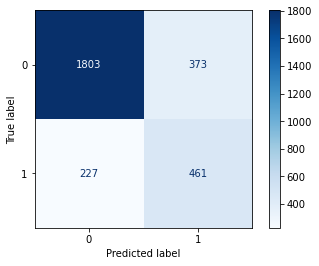

In [10]:
start_pipeline('cv', 'Mnb', 'Blues', pipe_params = {
                                'cv__max_features': [2_000, 4_500, 5_000, 5_500],
                                'cv__min_df' : [2,3], # ignore terms that show up less than 2 or 3 times in corpus
                                'cv__max_df' : [.5, .95], # ignore terms that show up either more than 50% or 95% of the corpus
                                'cv__ngram_range' : [(1,1), (1,2), (1,3)], # single words and bigrams
})

Slightly overfit with low precision score, F1 scores are above the .50 that we aim for but could be better

### Multinomial Naive Bayes with TFIDF Vectorizer

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.2min finished


Gridsearch best score is: 0.8072407882591403

Gridsearch best params are: {'tvec__max_df': 0.5, 'tvec__max_features': 6000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 3)}

MultinomialNB with TfidfVectorizer Train Score :  83.03%
MultinomialNB with TfidfVectorizer  Test Score  : 80.31%

MultinomialNB with TfidfVectorizer  F1- Train Score: 61.31%
MultinomialNB with TfidfVectorizer  F1- Test Score:  54.52%

61.23% of the words were predicted correctly by the model.
49.13% of the Skipped songs were found.
The specificity is: 85.30%


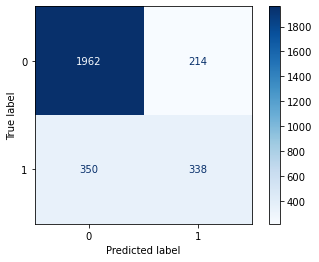

In [11]:

start_pipeline('tvec', 'Mnb', 'Blues', pipe_params = {
                                                        'tvec__max_features': [4_000, 5_000, 6_000, 7_000],
                                                        'tvec__ngram_range': [(1,1), (1,2), (1,3)],
                                                        'tvec__min_df' : [2,3], 
                                                        'tvec__max_df' : [.5, .95]})

Better precision score, however still overfit with F1 scores being further apart than before

### Bernoulli Naive Bayes with Count Vectorizer<a id='Bnb'></a>  

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 11.9min finished


Gridsearch best score is: 0.7968808516200163

Gridsearch best params are: {'Bnb__alpha': 0.275, 'cv__max_df': 0.5, 'cv__max_features': 9000, 'cv__min_df': 3, 'cv__ngram_range': (1, 2)}

BernoulliNB with CountVectorizer Train Score :  80.36%
BernoulliNB with CountVectorizer  Test Score  : 80.13%

BernoulliNB with CountVectorizer  F1- Train Score: 65.52%
BernoulliNB with CountVectorizer  F1- Test Score:  65.24%

56.27% of the words were predicted correctly by the model.
77.62% of the Skipped songs were found.
The specificity is: 76.73%


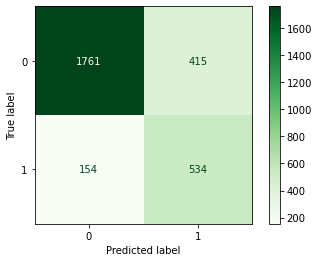

In [12]:
start_pipeline('cv', 'Bnb', 'Greens', pipe_params = {
                                                    'Bnb__alpha' : np.linspace(0.2,0.5,5),
                                                    'cv__max_features': [5_000, 5_500, 7_000, 9_000],
                                                    'cv__min_df' : [2,3],
                                                    'cv__max_df' : [.5, .95],
                                                    'cv__ngram_range' : [(1,1), (1,2), (1,3)]})

Scores are good, but still low on the precision score

### Bernoulli Naive Bayes with TFIDF Vectorizer

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 18.7min finished


Gridsearch best score is: 0.7958330539793217

Gridsearch best params are: {'Bnb__alpha': 0.425, 'tvec__max_df': 0.5, 'tvec__max_features': 7000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}

BernoulliNB with TfidfVectorizer Train Score :  80.24%
BernoulliNB with TfidfVectorizer  Test Score  : 80.24%

BernoulliNB with TfidfVectorizer  F1- Train Score: 65.40%
BernoulliNB with TfidfVectorizer  F1- Test Score:  65.28%

56.48% of the words were predicted correctly by the model.
77.33% of the Skipped songs were found.
The specificity is: 76.85%


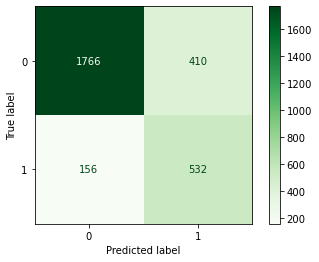

In [13]:
start_pipeline('tvec', 'Bnb', 'Greens', pipe_params = {
                                                'Bnb__alpha' : np.linspace(0.2,0.5,5),
                                                'tvec__max_features': [4_000, 5_000, 6_000, 7_000],
                                                'tvec__ngram_range': [(1,1), (1,2), (1,3)],
                                                'tvec__min_df' : [2,3], 
                                                'tvec__max_df' : [.5, .95],
})

Slightly higher than above on the precision, still alot of misclassified lyrics

### Logistic Regressions with Count Vectorizer<a id='Lg'></a>  

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 18.6min finished


Gridsearch best score is: 0.8121274179359498

Gridsearch best params are: {'cv__max_df': 0.5, 'cv__max_features': 9000, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'lg__C': 0.5, 'lg__max_iter': 5000, 'lg__penalty': 'l2'}

LogisticRegression with CountVectorizer Train Score :  99.74%
LogisticRegression with CountVectorizer  Test Score  : 81.91%

LogisticRegression with CountVectorizer  F1- Train Score: 99.46%
LogisticRegression with CountVectorizer  F1- Test Score:  62.13%

62.50% of the words were predicted correctly by the model.
61.77% of the Skipped songs were found.
The specificity is: 81.88%


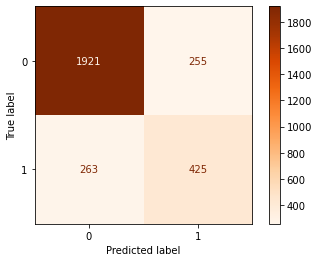

In [14]:
start_pipeline('cv', 'lg', 'Oranges', pipe_params = {'cv__max_features': [5_000, 5_500, 9_000],
                                         'cv__min_df' : [2,3],
                                         'cv__max_df' : [.5, .95],
                                         'cv__ngram_range' : [(1,1), (1,2), (1,3)],
                                         'lg__penalty' : ['l1', 'l2'],
                                         'lg__C' : [0.5,1.0,2.5],
                                         'lg__max_iter' : [5000]})


Way overfit

### Logistic Regressions with TFIDF Vectorizer

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 12.8min finished


Gridsearch best score is: 0.8203931137373776

Gridsearch best params are: {'lg__C': 2.5, 'lg__max_iter': 5000, 'lg__penalty': 'l2', 'tvec__max_df': 0.5, 'tvec__max_features': 5000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}

LogisticRegression with TfidfVectorizer Train Score :  89.21%
LogisticRegression with TfidfVectorizer  Test Score  : 81.98%

LogisticRegression with TfidfVectorizer  F1- Train Score: 73.85%
LogisticRegression with TfidfVectorizer  F1- Test Score:  56.42%

67.34% of the words were predicted correctly by the model.
48.55% of the Skipped songs were found.
The specificity is: 85.78%


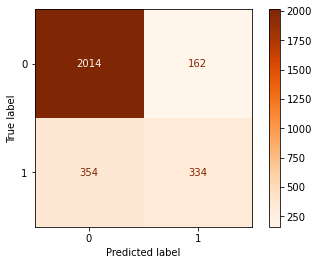

In [15]:
start_pipeline('tvec', 'lg', 'Oranges', pipe_params = {'tvec__max_features': [5_000, 5_500, 9_000],
                                            'tvec__min_df' : [2,3],
                                            'tvec__max_df' : [.5, .95],
                                            'tvec__ngram_range' : [(1,1), (1,2), (1,3)],
                                            'lg__penalty' : ['l1', 'l2'],
                                            'lg__C' : [0.5,1.0,2.5],
                                            'lg__max_iter' : [5000]})

Slightly better but not by much

### Random Forest with Count Vectorizer<a id='forest'></a>  
Trees do well with imbalanced classes

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 32.0min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 40.3min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 50.1min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 60.6min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 71.9min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 86.3min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 100.5min
[Parallel(n_jobs=-1)]: Done 9720 out of 9720 | elapsed: 117.6min finished


Gridsearch best score is: 0.8434414111677946

Gridsearch best params are: {'cv__max_df': 0.5, 'cv__max_features': 5000, 'cv__min_df': 2, 'cv__ngram_range': (1, 2), 'rdf__max_depth': None, 'rdf__min_samples_split': 14, 'rdf__n_estimators': 200}

RandomForestClassifier with CountVectorizer Train Score :  98.91%
RandomForestClassifier with CountVectorizer  Test Score  : 84.88%

RandomForestClassifier with CountVectorizer  F1- Train Score: 97.67%
RandomForestClassifier with CountVectorizer  F1- Test Score:  61.92%

78.40% of the words were predicted correctly by the model.
51.16% of the Skipped songs were found.
The specificity is: 85.52%


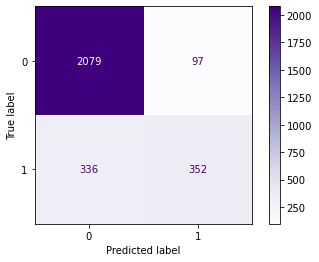

In [16]:
start_pipeline('cv', 'rdf', 'Purples', pipe_params = {'cv__max_features': [5_000, 5_500, 9_000],
                                           'cv__min_df' : [2,3],
                                           'cv__max_df' : [.5, .95],
                                           'cv__ngram_range' : [(1,1), (1,2), (1,3)],
                                            'rdf__min_samples_split': [14, 15, 16],
                                            'rdf__n_estimators': [100, 150, 200],
                                            'rdf__max_depth': [None, 1, 2, 3, 4, 5]})

Way Overfit

### Random Forest with TFIDF Vectorizer

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 24.5min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 42.2min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 49.7min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 58.1min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 67.6min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 78.3min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 90.1min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 103.3min
[Parallel(n_jobs=-1)]: Done 9720 out of 9720 | elapsed: 117.1min finished


Gridsearch best score is: 0.8428601516570602

Gridsearch best params are: {'rdf__max_depth': None, 'rdf__min_samples_split': 16, 'rdf__n_estimators': 200, 'tvec__max_df': 0.5, 'tvec__max_features': 5500, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 3)}

RandomForestClassifier with TfidfVectorizer Train Score :  99.12%
RandomForestClassifier with TfidfVectorizer  Test Score  : 84.92%

RandomForestClassifier with TfidfVectorizer  F1- Train Score: 98.12%
RandomForestClassifier with TfidfVectorizer  F1- Test Score:  61.77%

78.96% of the words were predicted correctly by the model.
50.73% of the Skipped songs were found.
The specificity is: 85.65%


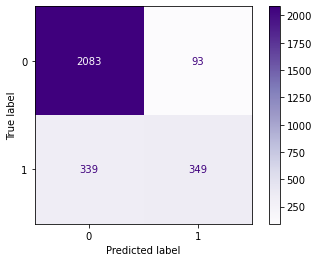

In [17]:
start_pipeline('tvec', 'rdf', 'Purples', pipe_params = {'tvec__max_features': [5_000, 5_500, 9_000],
                                           'tvec__min_df' : [2,3],
                                           'tvec__max_df' : [.5, .95],
                                           'tvec__ngram_range' : [(1,1), (1,2), (1,3)],
                                           'rdf__min_samples_split': [14, 15, 16],
                                           'rdf__n_estimators': [100, 150, 200],
                                            'rdf__max_depth': [None, 1, 2, 3, 4, 5]})

### Ada Boost with Count Vectorizer<a id='ada'></a>  

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.4min finished


Gridsearch best score is: 0.8852278275874446

Gridsearch best params are: {'ada__base_estimator': DecisionTreeClassifier(ccp_alpha=0.001, max_depth=1, min_samples_leaf=6), 'cv__max_df': 0.95, 'cv__max_features': 15000, 'cv__min_df': 2, 'cv__ngram_range': (1, 2)}

AdaBoostClassifier with CountVectorizer Train Score :  89.48%
AdaBoostClassifier with CountVectorizer  Test Score  : 89.28%

AdaBoostClassifier with CountVectorizer  F1- Train Score: 75.42%
AdaBoostClassifier with CountVectorizer  F1- Test Score:  74.90%

85.61% of the words were predicted correctly by the model.
66.57% of the Skipped songs were found.
The specificity is: 82.09%


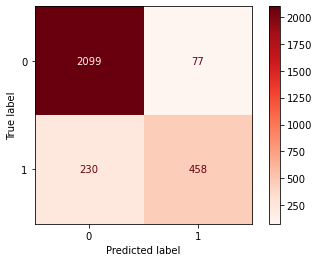

In [18]:
start_pipeline('cv', 'ada', 'Reds', pipe_params = {'cv__max_features': [15_000, 15_500, 16_000],
                                           'cv__min_df' : [2,3],
                                           'cv__max_df' : [.5, .95],
                                           'cv__ngram_range' : [(1,1), (1,2), (1,3)],
                                           'ada__base_estimator' : [DecisionTreeClassifier(ccp_alpha=0.001, min_samples_leaf=6, max_depth=1)]})

That's more like it! 

### Ada Boost with TFIDF Vectorizer

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 13.7min finished


Gridsearch best score is: 0.8789425993535241

Gridsearch best params are: {'ada__base_estimator': None, 'tvec__max_df': 0.5, 'tvec__max_features': 15500, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 3)}

AdaBoostClassifier with TfidfVectorizer Train Score :  89.02%
AdaBoostClassifier with TfidfVectorizer  Test Score  : 88.27%

AdaBoostClassifier with TfidfVectorizer  F1- Train Score: 74.59%
AdaBoostClassifier with TfidfVectorizer  F1- Test Score:  72.55%

82.84% of the words were predicted correctly by the model.
64.53% of the Skipped songs were found.
The specificity is: 82.44%


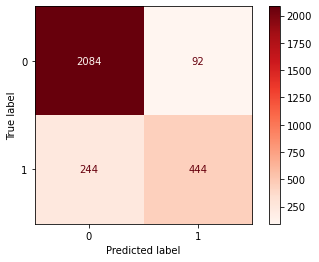

In [20]:
start_pipeline('tvec', 'ada', 'Reds', pipe_params = {'tvec__max_features': [15_000, 15_500, 16_000],
                                           'tvec__min_df' : [2,3],
                                           'tvec__max_df' : [.5, .95],
                                           'tvec__ngram_range' : [(1,1), (1,2), (1,3)],
                                           'ada__base_estimator' : [None, DecisionTreeClassifier(), RandomForestClassifier(), ExtraTreesClassifier()]})

Precision a little lower than the countvectorized Ada Boost Model, however the F1 scores and train/test scores are much closer to eachother on this one.  

### Feature Importance<a id='feature'></a>  
Using the AdaBoost model and count Vectorizer I will check to see what type 15 words helped the model predict the classes. The model and vectorizer will have the gridsearch's best parameters input.

In [29]:
cv = CountVectorizer(max_df=0.95, max_features=15_000, min_df=2,
                                 ngram_range=(1, 2),
                                 stop_words= 'english')  ## all params from gridsearch

In [41]:
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)
ada = AdaBoostClassifier() #instantiating the model
ada.fit(X_train_cv, y_train);

#### Extracting Feature Importance to plot

In [83]:
sorted_feat = ada.feature_importances_.argsort()[::-1] # sorting feature importance based on gini weight
words = np.take(cv.get_feature_names(), sorted_feat[:15]) # getting feature names from count vectorizer
feat = pd.DataFrame((list(zip(words, sorted_feat))),columns = ['Features', 'Importance']) # creating a dataframe 
feat.set_index(feat.Features, inplace=True) # setting the feature name as index for y axis
unit = feat[:15].sort_values('Importance', ascending=False)['Importance'] # sort by importance show top 15
color = ["#399BC6" if i > 10_000 else '#91D4BC' for i in unit] # 2 colors, features that are more than 10_000
labels = unit.index # setting labels to the index

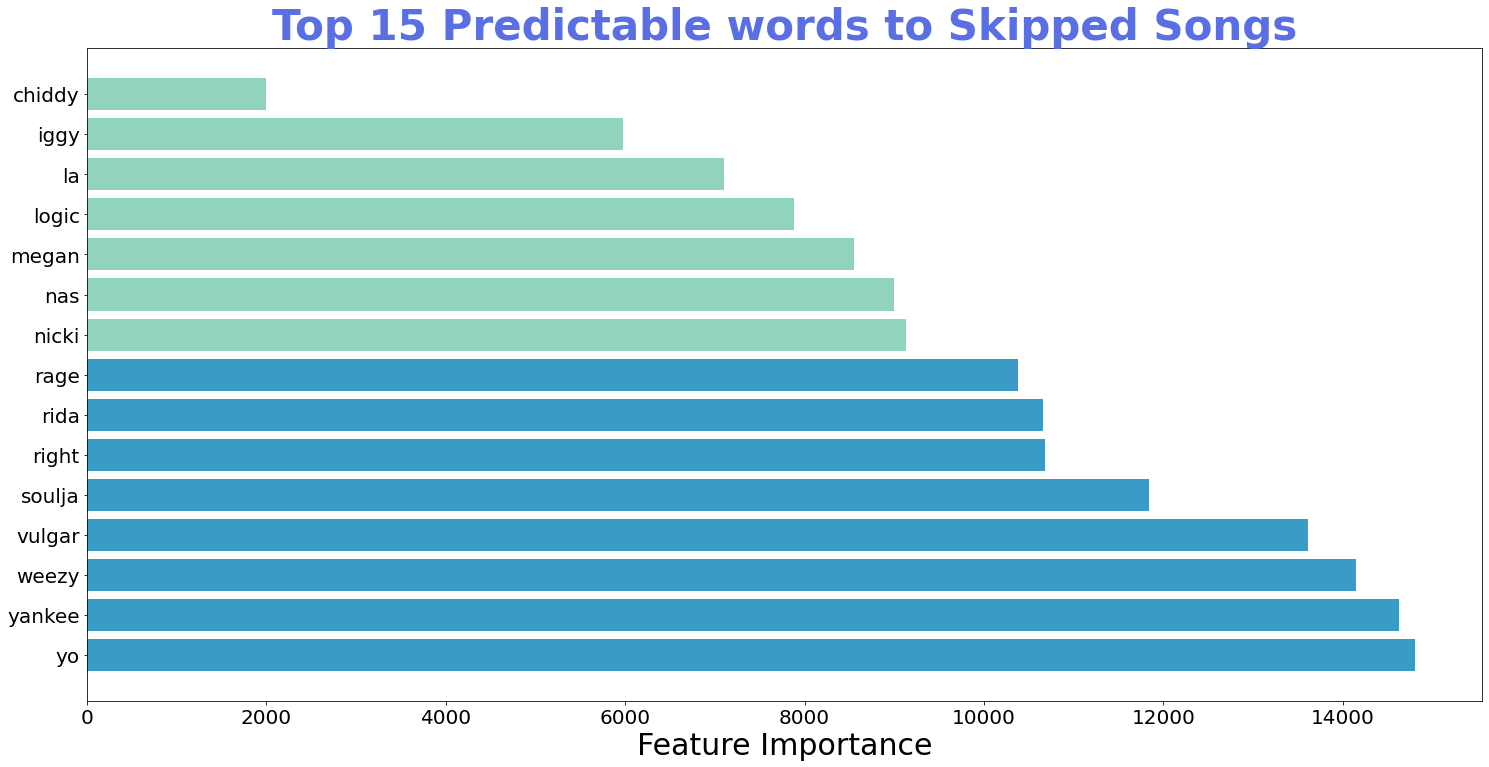

In [85]:
#plotting
plt.figure(figsize=(25,12))
plt.barh(labels, unit, color = color)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Feature Importance', fontsize=30)
plt.title(f'Top {15} Predictable words to Skipped Songs', fontsize=42, color ="#596FE3", weight='bold')
plt.savefig(f'./visuals/pred_words_cv.png', transparent=True, bbox_inches='tight'); #saving


Apart from *'vulgar'* these words did not appear in my top 15 words in my EDA, it also makes a lot of sense as to why they have such heavy importance in determining which classes they belong to. 
With the exception of *'right', 'yo', 'la'* all the other words are aliases / names of the artists.

### Score Visualization<a id='viz'></a>  
Combining all the scores I extracted from each model run through the pipeline.

In [90]:
recall

[0.6700581395348837,
 0.49127906976744184,
 0.7761627906976745,
 0.7732558139534884,
 0.6177325581395349,
 0.48546511627906974,
 0.5116279069767442,
 0.5072674418604651,
 0.6656976744186046,
 0.6453488372093024]

### Conclusion<a id='conc'></a>
Of all my models here, the AdaBoost with CountVectorizer did the best. With a precision score of 85.61%, speicificity at 82.09% and the train test scores in both the model score and F1 score being minimally apart, showing little sign of overfitting.
The best params being bi-grams and max_features at 15,000. To note I did add some options in the pipe params for AdaBoost, but it performed better with its standard settings.


<b> What's next? </b>
I ran these models with a Word Lemmatizer in the [next notebook](./4.1.2_Model_Word_Lem.ipynb) to see if it will help my model's predictions be more precise, the conclusion on that was that the models performed marginally worse than here, but overall the AdaBoost models performed better with Lemmatizing as well.

<br> I also re-ran the AdaBoost model with the best params through different options for re-balancing in [this notebook](./4.1.3_Model-Resampling.ipynb), of all the options I liked the results of the RandomOverSampling, although the model did lose 183 Not Skipped songs, it found an additional 73 Skipped songs. The other methods, (SMOTE & NearMiss) found more Skipped songs, but at a greater loss for the not skipped songs, compared to ROS</br> 

<br>Finally, I am attempting to better my scores with [Neural Networks](./4.2_Model_RNN.ipynb), because of the class imbalance I am trying different options such as re-weighing the classes, and applying the oversampling to the neural networks. I will be using GridSearchCV there as well to try and tune the hyper-parameters for the best outcome.</br>